# Multi task learning ResNet50 based model with ImageNet weights and best hyperparameters

Running a frozen ResNet50 conv base + 3 x {[128] FC layer + [out layer]} for age group, gender and race classifications with best hyperparameters.

Best Hyperparameters: <br>
learning rate = 0.001 and batch size = 16.

Here, a multi task learning is applied to train a deep network for age group, gender and race classifications. A ResNet50 convolutional base (He et al., 2016), trained on ImageNet (Deng, 2009) is connected to three separate fully connected (FC) layers along with output layers to achieve the respective classifications. Through transfer learning, the weights of trained model on ImageNet are loaded to the frozen convolutional base. Then, the model is trained.

## 1. Dataset
In this section, an exploratory data analysis (EDA) of the UTKFace data (Song, Zhang and Qi, 2017) used in this study is carried out.
<br> It is required to install keras-cv to apply random rotations in augmenting data.

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 61.7 MB/s eta 0:00:00


The following shows the required imports to run this colab file.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import set_random_seed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import keras_cv
from keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.callbacks import Callback

Now, the seed is set to a random integer so that same sequence of random numbers are generated each time the programme is run. Therefore, this ensures that the results are reproducible.

In [ ]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(42)

Here, my Google Drive is connected to this Colab file.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Below folder contains the cropped faces of the UTKFace data (Song, Zhang and Qi, 2017) from the "RetinaFace" algorithm (Deng et al., 2020). This deep learning based algorithm was used to extract faces with a fixed spatial resolution of 100 x 100 and save them in RGB image form.

In [ ]:
folder_path = "/content/drive/My Drive/UTKFace_retina_cropped_100x100"

Following shows the total number of facial images stored in the folder.

In [ ]:
cnt = 0
for file in sorted(os.listdir(folder_path)):  # Sort file list
  file_path = os.path.join(folder_path,file)
  cnt = cnt + 1

print(f"Number of face images: {cnt}")

Number of face images: 23561


The following code creates a donut chart on gender and race percentages in UTKFace dataset used in this work. The outer circle shows the gender distribution as a percentage and the inner circle shows the race percentages associated with each gender.

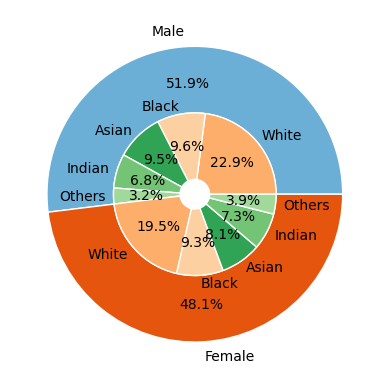

In [ ]:
# age: is an integer from 0 to 116, indicating the age
# gender: is either 0 (male) or 1 (female)
# race: is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

column_names = ['Age', 'Gender', 'Race']
records = []

for file in os.listdir(folder_path):
  records.append(file.split('_')[:-1])

DFrame=pd.DataFrame(records, columns=column_names).astype(int)

# EDA: Donut chart
fig, ax = plt.subplots()
cmap = plt.colormaps["tab20c"]
outer_colors = cmap([1,4])
inner_colors = cmap([6,7,8,9,10, 6,7,8,9,10])
size = 0.45
pctdist = 0.75

DF_tot = DFrame['Gender'].value_counts()

# Outer pie chart
ax.pie(
    np.array(DF_tot),
    autopct='%1.1f%%',
    pctdistance = pctdist,
    radius=1.0,
    colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['Male', 'Female']    #[0, 1]
);

# Counts of races in females
DF_F = DFrame.Race[DFrame['Gender']==1].value_counts()

# Counts of races in males
DF_M = DFrame.Race[DFrame['Gender']==0].value_counts()

# Concatenate arrays, for use in inner pie chart
concat_arrays= np.concatenate((np.array(DF_M), np.array(DF_F)))

# Inner pie chart (to show sub-distribution of "race")
ax.pie(
    concat_arrays,
    autopct='%1.1f%%',
    radius=1.0-size,
    colors=inner_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['White','Black','Asian','Indian', 'Others',
            'White','Black','Asian','Indian', 'Others',]
);

The following code shows the race distribution in the UTKFace data used in this study. The race mapping is used to map the different races to their ineger values obtained from the image labels.

Text(0.5, 1.0, 'Distribution of race in the UTKFace dataset')

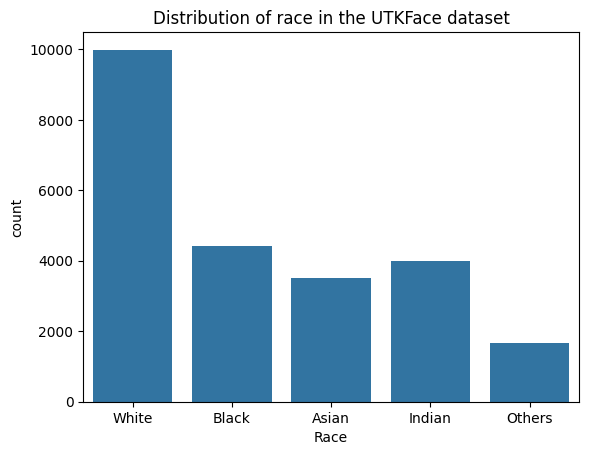

In [ ]:
# Race Mapping
race_mapping = {
    0 : 'White',
    1 : 'Black',
    2 : 'Asian',
    3 : 'Indian',
    4 : 'Others'
}

# Replacing the integers with correct race
DFrame['Race'] = DFrame['Race'].replace(race_mapping)

# Specifying the order of categories based on race_mapping
race_order = list(race_mapping.values())

# Count plot
plt.figure()
sns.countplot(x='Race', data=DFrame, order=race_order)
plt.title('Distribution of race in the UTKFace dataset')

The following code divides the age range into 5 different age categories as Child, Youth, Adult, Middle Age and Old. The age ranges of the above categories are as follows: <br>

| Age Group     | Year Range     |
|---------------|----------------|
| Child         | 0-14    |
| Youth         | 14-25   |
| Adult         | 25-40   |
| Middle Age    | 40-60   |
| Old           | 60+     |

Then, the age group distribution of the UTKFace data used in this study is shown separately and along with gender.

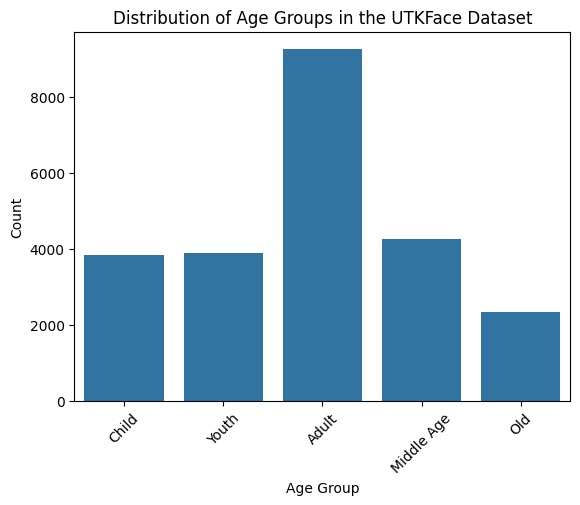

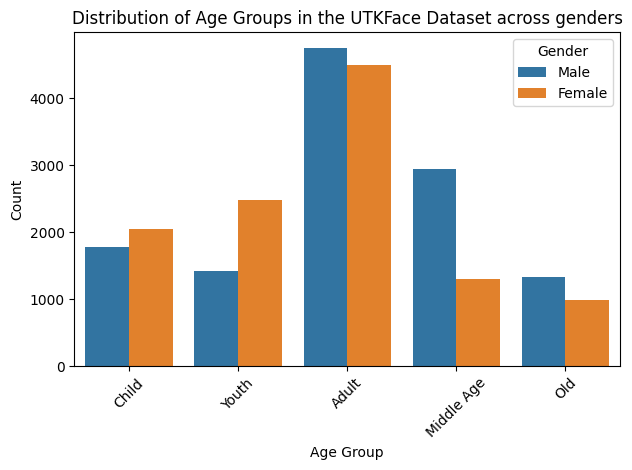

In [ ]:
# Age distribution

# Defining bins and labels
bins = [0, 14, 25, 40, 60, 116]
labels = ["Child", "Youth", "Adult", "Middle Age", "Old"]

# Classifying ages into groups
DFrame['Age_Group'] = pd.cut(DFrame['Age'], bins=bins, labels=labels, right=True)  # (0, 14], (14,25], (25, 40], (40, 60] and (60, 116]

# Plotting the distribution of age groups
fig1, ax1 = plt.subplots()
sns.countplot(x='Age_Group', data=DFrame, ax=ax1)
ax1.set_title('Distribution of Age Groups in the UTKFace Dataset')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Count')


# Race Mapping
gender_mapping = {
    0 : 'Male',
    1 : 'Female'
}
# Replacing the integers with correct gender
DFrame['Gender'] = DFrame['Gender'].replace(gender_mapping)

# Plotting the distribution of age groups with gender
fig1, ax2 = plt.subplots()
sns.countplot(x='Age_Group', hue='Gender', data=DFrame, ax=ax2)
ax2.set_title('Distribution of Age Groups in the UTKFace Dataset across genders')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Count')

# Rotating x-tick labels for both axes
for label in ax1.get_xticklabels():
  label.set_rotation(45)  # Rotating x-tick labels by 45 degrees

for label in ax2.get_xticklabels():
  label.set_rotation(45)  # Rotating x-tick labels by 45 degrees

plt.tight_layout()
plt.show()

The following function "labeling_age_group_tf" returns the age group label given the age and a tensor called bins containing bin locations. Since the age groups are divided into 5 categories, bins = [0, 14, 25, 40, 60, 116] which indicate the boundaries of age groups. The given age is checked in each defined age group and recorded its state in a boolean tensor. The location where the boolean tensor is true gives the integer label associated with each age group.

The inter mapping of age group is as follows:

| Age Group     | Year Range     | Integer Label  |
|---------------|----------------|----------------|
| Child         | 0-14           |       0        |
| Youth         | 14-25          |       1        |
| Adult         | 25-40          |       2        |
| Middle Age    | 40-60          |       3        |
| Old           | 60+            |       4        |

In [ ]:
def labeling_age_group_tf(age, bins):
    # Converting bins and age to TensorFlow constants
    bins = tf.constant(bins, dtype=tf.int32)

    # Creating labels from 0 to len(bins) - 2
    age_groups = tf.range(len(bins) - 1, dtype=tf.int32)

    # Finding the appropriate age group
    conditions = tf.logical_and(age > bins[:-1], age <= bins[1:])
    label = tf.reduce_sum(tf.where(conditions, age_groups, 0))

    return label

Each facial image is labeled in the format  age_gender_race_date&time.jpg. The function "read_image" splits the label of an image and separately returns age group, gender and race integer labels along with the associated facial image. The function "labeling_age_group_tf" is used here to identify the age group associated with the age.

In [ ]:
def read_image(fname):
    # Extracting label from file name
    parts = tf.strings.split(fname, os.sep)
    file_name = parts[-1]
    multiple_labels = tf.strings.split(file_name, '_')

    # Converting age label to integer
    age_label = tf.strings.to_number(multiple_labels[0], out_type=tf.int32)

    # Defining age bins
    bins = [0, 14, 25, 40, 60, 116]

    # Extracting labels (age, gender, race)
    age_label =  labeling_age_group_tf(age_label, bins)  # First part: age
    gender_label = tf.strings.to_number(multiple_labels[1], out_type=tf.int32)     # Second part: gender
    race_label = tf.strings.to_number(multiple_labels[2], out_type=tf.int32)       # Third part: race

    # Converting race label to integer
    label = tf.strings.to_number(multiple_labels[2], out_type=tf.int32)

    # Loading and decoding the image
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    return image, age_label, gender_label, race_label

The following code preprocess each image and applies random transformations if augment is true. The images are initially normalised. Then, if the augment argument is true, each image is augmented in following ways: random flip left-right random brightness random contrast random rotation upto 20 degrees Finally, this function returns the preprocessed image along with its separate age group, gender and race labels.

In [ ]:
# Defining the rotation layer outside the function for reuse
rotation_layer = keras_cv.layers.RandomRotation(factor=0.111)  # 0.111 ~= 20 degrees

def preprocess_image(image, age_label, gender_label, race_label, augment):
    # Converting image to float32 and normalize to [0,1]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    if augment:
        # Applying augmentation
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
        # Rotating up to 20 degrees using KerasCV
        image = rotation_layer(image)

    return image, age_label, gender_label, race_label

This below code splits a dataset of file paths into training (80%), validation (10%), and test (10%) sets using TensorFlow's tf.data.Dataset API. It starts by listing all files in a specified folder and shuffling them for randomness with a fixed seed for reproducibility. The dataset is then divided: the first 80% of files are taken for training, the next 10% for validation, and the remaining 10% for testing.

In [ ]:
# Creating training, validation and test sets.
list_ds = tf.data.Dataset.list_files(folder_path + "/*")

# Total number of files
file_count = len(list_ds)

# Defining split sizes
train_size = int(0.8 * file_count)  # 80% for training
val_size = int(0.1 * file_count)    # 10% for validation
test_size = file_count - train_size - val_size  # Remaining 10% for testing

# Shuffling the dataset before splitting
list_ds = list_ds.shuffle(buffer_size=file_count, seed=42)

# Splitting into training, validation, and test datasets
train_list_ds = list_ds.take(train_size)  # First 80% for training
val_list_ds = list_ds.skip(train_size).take(val_size)  # Next 10% for validation
test_list_ds = list_ds.skip(train_size + val_size)  # Remaining 10% for test

# for element in list_ds.as_numpy_iterator():
#   print(element)
#   break

The below code processes training, validation, and test datasets. Each dataset is prepared by mapping file paths to images using read_image, followed by applying preprocessing with preprocess_image (without augmentation). Labels for age, gender, and race are formatted into a dictionary with keys age_output, gender_output, and race_output. The datasets are batched with a size of 16, cached for faster reuse, and prefetched to improve performance by preparing the next batch while the current one is being processed. The use of tf.data.AUTOTUNE optimizes parallelism and performance.

In [ ]:
batch_size = 16  # best batch size
lr = 0.001       # best learning rate

# Updated dataset preparation with preprocessing
train_ds = (
    train_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         preprocess_image(img, age_lbl, gender_lbl, race_lbl, augment=False),  # Applying preprocessing without augmentation
         num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         (img, {'age_output': age_lbl, 'gender_output': gender_lbl, 'race_output': race_lbl}),  # Formatting the labels
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         preprocess_image(img, age_lbl, gender_lbl, race_lbl, augment=False),  # Applying preprocessing without augmentation
         num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         (img, {'age_output': age_lbl, 'gender_output': gender_lbl, 'race_output': race_lbl}),  # Formatting the labels
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         preprocess_image(img, age_lbl, gender_lbl, race_lbl, augment=False),  # Applying preprocessing without augmentation
         num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_lbl, gender_lbl, race_lbl:
         (img, {'age_output': age_lbl, 'gender_output': gender_lbl, 'race_output': race_lbl}),  # Formatting the labels
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


The following code shows the shape of the images in the first batch and all labels of images in the first batch. These labels include age group, gender and race.

In [ ]:
# Sample check
for img, labels in train_ds.take(1):  # Take one batch
    print("Image shape:", img.shape)  # Print image shape
    print("Labels dictionary:", labels)  # Print labels dictionary

    # Accessing individual labels
    age_lbl = labels['age_output']
    gender_lbl = labels['gender_output']
    race_lbl = labels['race_output']

    print("Age labels:", age_lbl.numpy())
    print("Gender labels:", gender_lbl.numpy())
    print("Race labels:", race_lbl.numpy())


Image shape: (16, 100, 100, 3)
Labels dictionary: {'age_output': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([3, 2, 3, 2, 3, 0, 4, 2, 3, 0, 0, 2, 2, 1, 3, 4], dtype=int32)>, 'gender_output': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int32)>, 'race_output': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 3, 1, 3, 0, 0, 0, 3, 0, 0, 1, 3, 3, 4, 0, 0], dtype=int32)>}
Age labels: [3 2 3 2 3 0 4 2 3 0 0 2 2 1 3 4]
Gender labels: [0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1]
Race labels: [0 3 1 3 0 0 0 3 0 0 1 3 3 4 0 0]


The following code shows the first image of the first batch along with the labels as an example image in the training data.

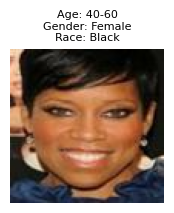

Age Label: 40-60, Age Integer: 3
Gender Label: Female, Gender Integer: 1
Race Label: Black, Race Integer: 1


In [ ]:
# Defining label names for the tasks
age_labels = ["0-14", "14-25", "25-40", "40-60", "60+"]
gender_labels = ["Male", "Female"]
race_labels = ["White", "Black", "Asian", "Indian", "Others"]

img_no = 0

# Looping through the dataset to extract and visualising one example image
for img, labels in train_ds.take(1):
    img0 = img[img_no]

    # Unpacking individual labels
    age_int_labels = labels['age_output']
    gender_int_labels = labels['gender_output']
    race_int_labels = labels['race_output']

    age_label = age_labels[age_int_labels[img_no]]
    gender_label = gender_labels[gender_int_labels[img_no]]
    race_label = race_labels[race_int_labels[img_no]]

    # Displaying the image with the labels
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(img0)
    ax.axis('off')
    ax.set_title(f"Age: {age_label}\nGender: {gender_label}\nRace: {race_label}", fontsize=8)
    plt.show()

    # Printing detailed information
    print(f"Age Label: {age_label}, Age Integer: {age_int_labels[img_no]}")
    print(f"Gender Label: {gender_label}, Gender Integer: {gender_int_labels[img_no]}")
    print(f"Race Label: {race_label}, Race Integer: {race_int_labels[img_no]}")


    img_no = img_no + 1
    if img_no == batch_size:
       img_no = 0
    # Breaking after first example
    break

## 2. Building a CNN using Transfer Learning on ResNet50
Input image shape: (100, 100, 3)

This multi-task deep learning model is designed for simultaneous gender, age group, and race classifications. The input is an image of shape (100, 100, 3). It begins by creating a convolutional neural network (CNN) based on a modified ResNet50 architecture (He et al., 2016). ResNet50's convolutional base consists of multiple residual blocks, each containing convolutional layers with skip connections that help preserve feature information while progressively extracting spatial features and reducing dimensionality. This ResNet convolutional base, trained on ImageNet (Deng, 2009) is then connected to three separate fully connected (FC) layers and the respective output layers to achieve the multiple classifications. Through transfer learning, the weights of trained model on ImageNet are loaded to the frozen convolutional base. Then all FCs are allowed to train with the best hyperparameters.

Model Summary:
Running frozen ResNet50 conv base + 3 x {[128] FC layer + [out layer]} for age group, gender and race classifications with best hyper-parameters found.

In [ ]:
from tensorflow.keras.applications import resnet50
base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in base_model.layers:
    layer.trainable = False

# Flattening the base_model output
flatten = layers.GlobalAveragePooling2D()(base_model.output)

# Gender classification
gender = layers.Dense(128, activation='relu', name='gender_fc1')(flatten)
gender_out = layers.Dense(2, activation='softmax', name='gender_output')(gender)

# Age group classification
age_group = layers.Dense(128, activation='relu', name='age_fc1')(flatten)
age_out = layers.Dense(5, activation='softmax', name='age_output')(age_group)

# Race classifaction
race = layers.Dense(128, activation='relu', name='race_fc1')(flatten)
race_out = layers.Dense(5, activation='softmax', name='race_output')(race)

# Multi-task Model
model = models.Model(inputs=base_model.input, outputs=[age_out, gender_out, race_out], name='multi_task_model')
# Printing the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "multi_task_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 106, 106, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 50, 50, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 50, 50, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 50, 50, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 52, 52, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 25, 25, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 25, 25, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 25, 25, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 25, 25, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 25, 25, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,376,076 (92.99 MB)

 Trainable params: 788,364 (3.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

The CombinedAccuracyCallback shown below is a Keras callback designed to monitor and improve the combined accuracy of a multi-task model. It computes a weighted average of training and validation accuracies across age, gender, and race classification tasks at the end of each epoch. The weights (0.4 for age and 0.4 for race, 0.2 for gender) reflect their relative importance. The callback tracks these combined accuracies, logs them, and stores the values in lists for visualization or further analysis. If the combined validation accuracy improves, it saves the model to a specified checkpoint path.

In [ ]:
class CombinedAccuracyCallback(keras.callbacks.Callback):
  def __init__(self, checkpoint_path):
    super().__init__()
    self.best_accuracy = 0  # Initializing the best validation accuracy as 0
    self.best_loss = float('inf')  # Initializing the best validation loss
    self.checkpoint_path = checkpoint_path  # Path to save the best model
    self.train_accuracies = []  # List to store combined training accuracies
    self.val_accuracies = []    # List to store combined validation accuracies
    self.train_losses = []      # List to store combined training losses
    self.val_losses = []        # List to store combined validation losses

  def on_epoch_end(self, epoch, logs=None):
    # Calculating combined training accuracy
    combined_train_accuracy = (
        0.4 * logs.get('age_output_accuracy', 0) +
        0.2 * logs.get('gender_output_accuracy', 0) +
        0.4 * logs.get('race_output_accuracy', 0)
    )
    # Calculating combined validation accuracy
    combined_val_accuracy = (
        0.4 * logs.get('val_age_output_accuracy', 0) +
        0.2 * logs.get('val_gender_output_accuracy', 0) +
        0.4 * logs.get('val_race_output_accuracy', 0)
    )
    # Calculating combined training loss
    combined_train_loss = (
        0.4 * logs.get('age_output_loss', 0) +
        0.2 * logs.get('gender_output_loss', 0) +
        0.4 * logs.get('race_output_loss', 0)
    )
    # Calculating combined validation loss
    combined_val_loss = (
        0.4 * logs.get('val_age_output_loss', 0) +
        0.2 * logs.get('val_gender_output_loss', 0) +
        0.4 * logs.get('val_race_output_loss', 0)
    )

    # Printing combined accuracies
    # print(f"Epoch {epoch + 1}: Combined Training Accuracy = {combined_train_accuracy:.4f}")
    # print(f"\nEpoch {epoch + 1}: Combined Validation Accuracy = {combined_val_accuracy:.4f}")
    # Printing combined losses
    # print(f"Epoch {epoch + 1}: Combined Training Loss = {combined_train_loss:.4f}")
    # print(f"\nEpoch {epoch + 1}: Combined Validation Loss = {combined_val_loss:.4f}")

    print(f"Epoch {epoch + 1}: Combined Training Accuracy = {combined_train_accuracy:.4f}, Combined Validation Accuracy = {combined_val_accuracy:.4f}, Combined Training Loss = {combined_train_loss:.4f}, Combined Validation Loss = {combined_val_loss:.4f}")

    # Save metrics
    self.train_accuracies.append(combined_train_accuracy)
    self.val_accuracies.append(combined_val_accuracy)
    self.train_losses.append(combined_train_loss)
    self.val_losses.append(combined_val_loss)

    # Saving the model if combined validation accuracy improves
    if combined_val_accuracy > self.best_accuracy:
      print(f"New best combined accuracy! Saving model to {self.checkpoint_path}")
      self.best_accuracy = combined_val_accuracy
      self.model.save(self.checkpoint_path)  # Saving the model
    else:
      print("Combined validation accuracy did not improve.")

  def on_train_end(self, logs=None):
   self.history = {
       'combined_train_acc': self.train_accuracies,
       'combined_val_acc': self.val_accuracies,
       'combined_train_loss': self.train_losses,
       'combined_val_loss': self.val_losses
   }


# Creating the checkpoint callback
checkpoint_path = "/content/drive/My Drive/checkpoint/weights.keras"
#mc_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
combined_accuracy_callback = CombinedAccuracyCallback(checkpoint_path)

The following code views current status of each layer in the convolutional base.

In [ ]:
# Printing layer numbers and details
cnt = 1
for layer in base_model.layers:
    print(f'{cnt}: {layer.name} - {"Trainable" if layer.trainable else "Frozen"}')
    cnt += 1

1: input_layer - Frozen
2: conv1_pad - Frozen
3: conv1_conv - Frozen
4: conv1_bn - Frozen
5: conv1_relu - Frozen
6: pool1_pad - Frozen
7: pool1_pool - Frozen
8: conv2_block1_1_conv - Frozen
9: conv2_block1_1_bn - Frozen
10: conv2_block1_1_relu - Frozen
11: conv2_block1_2_conv - Frozen
12: conv2_block1_2_bn - Frozen
13: conv2_block1_2_relu - Frozen
14: conv2_block1_0_conv - Frozen
15: conv2_block1_3_conv - Frozen
16: conv2_block1_0_bn - Frozen
17: conv2_block1_3_bn - Frozen
18: conv2_block1_add - Frozen
19: conv2_block1_out - Frozen
20: conv2_block2_1_conv - Frozen
21: conv2_block2_1_bn - Frozen
22: conv2_block2_1_relu - Frozen
23: conv2_block2_2_conv - Frozen
24: conv2_block2_2_bn - Frozen
25: conv2_block2_2_relu - Frozen
26: conv2_block2_3_conv - Frozen
27: conv2_block2_3_bn - Frozen
28: conv2_block2_add - Frozen
29: conv2_block2_out - Frozen
30: conv2_block3_1_conv - Frozen
31: conv2_block3_1_bn - Frozen
32: conv2_block3_1_relu - Frozen
33: conv2_block3_2_conv - Frozen
34: conv2_bloc

The following code views the current status of each layer in the full model.

In [ ]:
# Printing layer numbers and details
cnt = 1
for layer in model.layers:
    print(f'{cnt}: {layer.name} - {"Trainable" if layer.trainable else "Frozen"}')
    cnt += 1

1: input_layer - Frozen
2: conv1_pad - Frozen
3: conv1_conv - Frozen
4: conv1_bn - Frozen
5: conv1_relu - Frozen
6: pool1_pad - Frozen
7: pool1_pool - Frozen
8: conv2_block1_1_conv - Frozen
9: conv2_block1_1_bn - Frozen
10: conv2_block1_1_relu - Frozen
11: conv2_block1_2_conv - Frozen
12: conv2_block1_2_bn - Frozen
13: conv2_block1_2_relu - Frozen
14: conv2_block1_0_conv - Frozen
15: conv2_block1_3_conv - Frozen
16: conv2_block1_0_bn - Frozen
17: conv2_block1_3_bn - Frozen
18: conv2_block1_add - Frozen
19: conv2_block1_out - Frozen
20: conv2_block2_1_conv - Frozen
21: conv2_block2_1_bn - Frozen
22: conv2_block2_1_relu - Frozen
23: conv2_block2_2_conv - Frozen
24: conv2_block2_2_bn - Frozen
25: conv2_block2_2_relu - Frozen
26: conv2_block2_3_conv - Frozen
27: conv2_block2_3_bn - Frozen
28: conv2_block2_add - Frozen
29: conv2_block2_out - Frozen
30: conv2_block3_1_conv - Frozen
31: conv2_block3_1_bn - Frozen
32: conv2_block3_1_relu - Frozen
33: conv2_block3_2_conv - Frozen
34: conv2_bloc

Now, the model is visualised.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.858404 to fit



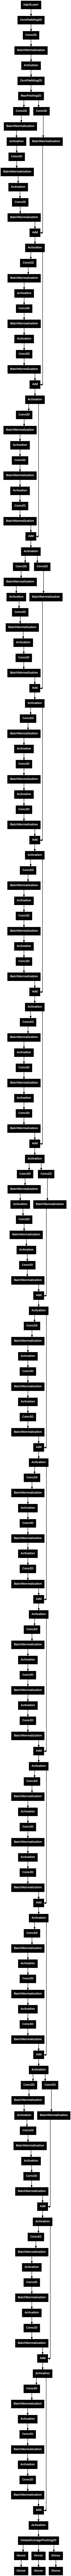

In [ ]:
plot_model(model)

In [ ]:
# Get trainable and non-trainable parameters
trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
non_trainable_params = np.sum([np.prod(w.shape) for w in model.non_trainable_weights])
total_params = model.count_params()

trainable_percent = np.round(trainable_params / total_params *100 ,2)

frame = pd.DataFrame({'Trainable Params': trainable_params,
                      'Non-trainable Params': non_trainable_params,
                      'Total Params': total_params,
                      'Trainable Param %':trainable_percent}, index=[0])
frame.head()

,Trainable Params,Non-trainable Params,Total Params,Trainable Param %
0,788364,23587712,24376076,3.23


In [ ]:
# Calculate size in bytes
model_size_bytes = total_params * 4  # 4 bytes per parameter (float32)

# Convert to kilobytes
model_size_kb = model_size_bytes / (1024)
print(f"Model Size in KB: {model_size_kb:.2f} KB")

# Convert to megabytes
model_size_mb = model_size_bytes / (1024 ** 2)
print(f"Model Size in MB: {model_size_mb:.2f} MB")

Model Size in KB: 95219.05 KB
Model Size in MB: 92.99 MB


This following code sets up callbacks for training a model, focusing on saving the best model and dynamically adjusting the learning rate. A CombinedAccuracyCallback monitors combined validation accuracy weighted across age group, gender and race classification tasks and saves the model's weights to a specified path in Google Drive if this combined validation accuracy improves. The LearningRateScheduler adjusts the learning rate during training. It remains constant for the first 20 epochs and then decays exponentially in subsequent epochs.

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Defining the checkpoint path in Google Drive
checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/'

# Defining the checkpoint path
checkpoint_path = os.path.join(checkpoint_dir, 'best_weights_z2_model.keras')

# Creating the checkpoint callback
#mc_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='combined_val_accuracy',
                              #save_best_only=True, mode='max')

combined_accuracy_callback = CombinedAccuracyCallback(checkpoint_path=checkpoint_path)

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * float(tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(scheduler)

The folllowing code compiles the multi-task model using the Adam optimizer with a learning rate of 0.001 and gradient clipping for stability. It defines separate loss functions (SparseCategoricalCrossentropy) for age, gender, and race predictions, with softmax activations already applied in the final layers. The losses are weighted (0.4 for age and 0.4 for race, 0.2 for gender) to reflect their relative importance. Accuracy is used as the evaluation metric for all tasks. This configuration optimizes the model for balanced multi-task performance.

In [ ]:
# Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
    loss={
        'age_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        'gender_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        'race_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    },

    loss_weights={
        'age_output': 0.4,
        'gender_output': 0.2,
        'race_output': 0.4,
    },

    metrics={
        'age_output': ['accuracy'],
        'gender_output': ['accuracy'],
        'race_output': ['accuracy'],
    }
)
# My model’s last layer has a softmax activation, thus from_logits=False

The following code trains the model for 30 epochs using the train_ds dataset and evaluates its performance on the val_ds dataset at the end of each epoch. The training is performed in batches of size 16. Two callbacks are used: combined_accuracy_callback monitors combined validation accuracy and saves the best model, while lr_callback dynamically adjusts the learning rate during training. The training process logs metrics for analysis and stores the training history for further evaluation.

In [ ]:
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    batch_size=batch_size,
    callbacks=[combined_accuracy_callback, lr_callback]
)

Epoch 1/30
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - age_output_accuracy: 0.3668 - age_output_loss: 0.6178 - gender_output_accuracy: 0.5698 - gender_output_loss: 0.1389 - loss: 1.3540 - race_output_accuracy: 0.4055 - race_output_loss: 0.5973Epoch 1: Combined Training Accuracy = 0.4408, Combined Validation Accuracy = 0.4686, Combined Training Loss = 0.5001, Combined Validation Loss = 0.4824
New best combined accuracy! Saving model to /content/drive/MyDrive/model_checkpoints/best_weights_z2_model.keras
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 7762s 7s/step - age_output_accuracy: 0.3668 - age_output_loss: 0.6178 - gender_output_accuracy: 0.5698 - gender_output_loss: 0.1389 - loss: 1.3540 - race_output_accuracy: 0.4055 - race_output_loss: 0.5973 - val_age_output_accuracy: 0.3960 - val_age_output_loss: 0.5801 - val_gender_output_accuracy: 0.6740 - val_gender_output_loss: 0.1219 - val_loss: 1.2679 - val_race_output_accuracy: 0.4385 - val_race_output_loss: 0.5648 - learning_rate: 0.0010
Epoch 2/30
11

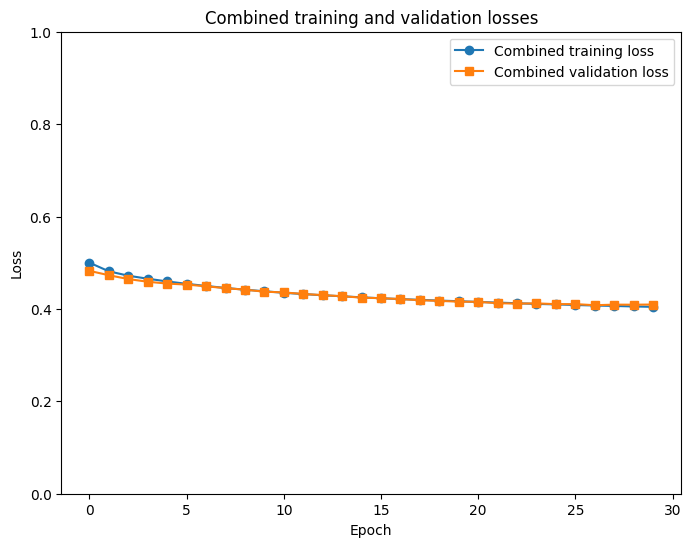

In [ ]:
# Plotting overall training and validation losses
train_combined_loss = combined_accuracy_callback.history['combined_train_loss']
val_combined_loss = combined_accuracy_callback.history['combined_val_loss']

fig, ax = plt.subplots(figsize=(8, 6))  # Create a single plot

# Plotting combined training and validation accuracies
ax.plot(train_combined_loss, label='Combined training loss', marker='o')
ax.plot(val_combined_loss, label='Combined validation loss', marker='s')

# Setting labels, title, and legend
ax.set_title('Combined training and validation losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim((0, 1))
ax.legend()
plt.show()

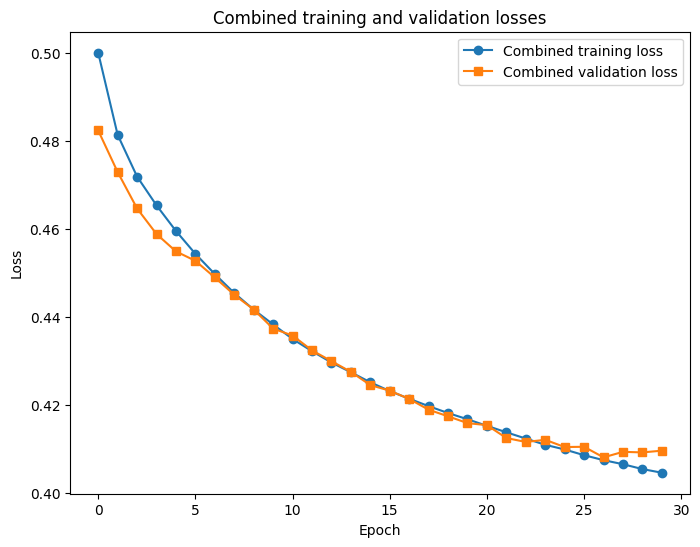

In [ ]:
# Plotting overall training and validation losses
train_combined_loss = combined_accuracy_callback.history['combined_train_loss']
val_combined_loss = combined_accuracy_callback.history['combined_val_loss']

fig, ax = plt.subplots(figsize=(8, 6))  # Create a single plot

# Plotting combined training and validation accuracies
ax.plot(train_combined_loss, label='Combined training loss', marker='o')
ax.plot(val_combined_loss, label='Combined validation loss', marker='s')

# Setting labels, title, and legend
ax.set_title('Combined training and validation losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

The following code plots the combined training and validation accuracies of the multi task model. Combined training and validation accuracies are obtained by weighting the respective accuracies by 0.4 for age, 0.4 for race and 0.2 for gender classifications.

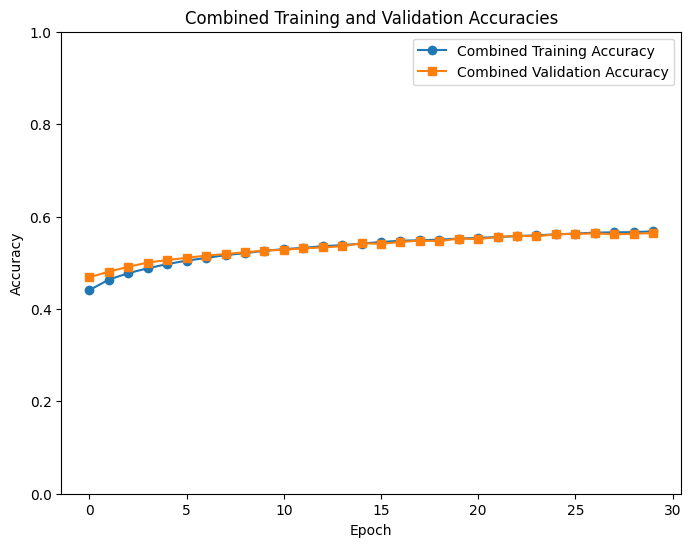

In [ ]:
# Plotting overall training and validation accuracies

train_combined_acc = combined_accuracy_callback.history['combined_train_acc']
val_combined_acc = combined_accuracy_callback.history['combined_val_acc']

fig, ax = plt.subplots(figsize=(8, 6))  # Create a single plot

# Plotting combined training and validation accuracies
ax.plot(train_combined_acc, label='Combined Training Accuracy', marker='o')
ax.plot(val_combined_acc, label='Combined Validation Accuracy', marker='s')

# Setting labels, title, and legend
ax.set_title('Combined Training and Validation Accuracies')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim((0, 1))
ax.legend()
plt.show()


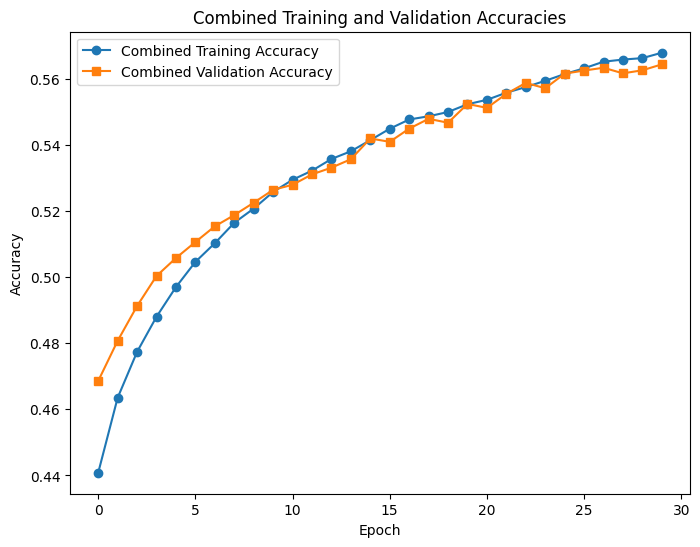

In [ ]:
# Plotting overall training and validation accuracies

train_combined_acc = combined_accuracy_callback.history['combined_train_acc']
val_combined_acc = combined_accuracy_callback.history['combined_val_acc']

fig, ax = plt.subplots(figsize=(8, 6))  # Create a single plot

# Plotting combined training and validation accuracies
ax.plot(train_combined_acc, label='Combined Training Accuracy', marker='o')
ax.plot(val_combined_acc, label='Combined Validation Accuracy', marker='s')

# Setting labels, title, and legend
ax.set_title('Combined Training and Validation Accuracies')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()


The following code plots the inidividual losses and accuracies of the training and validation datasets for the three separate tasks namely age group, gender and race classifications.

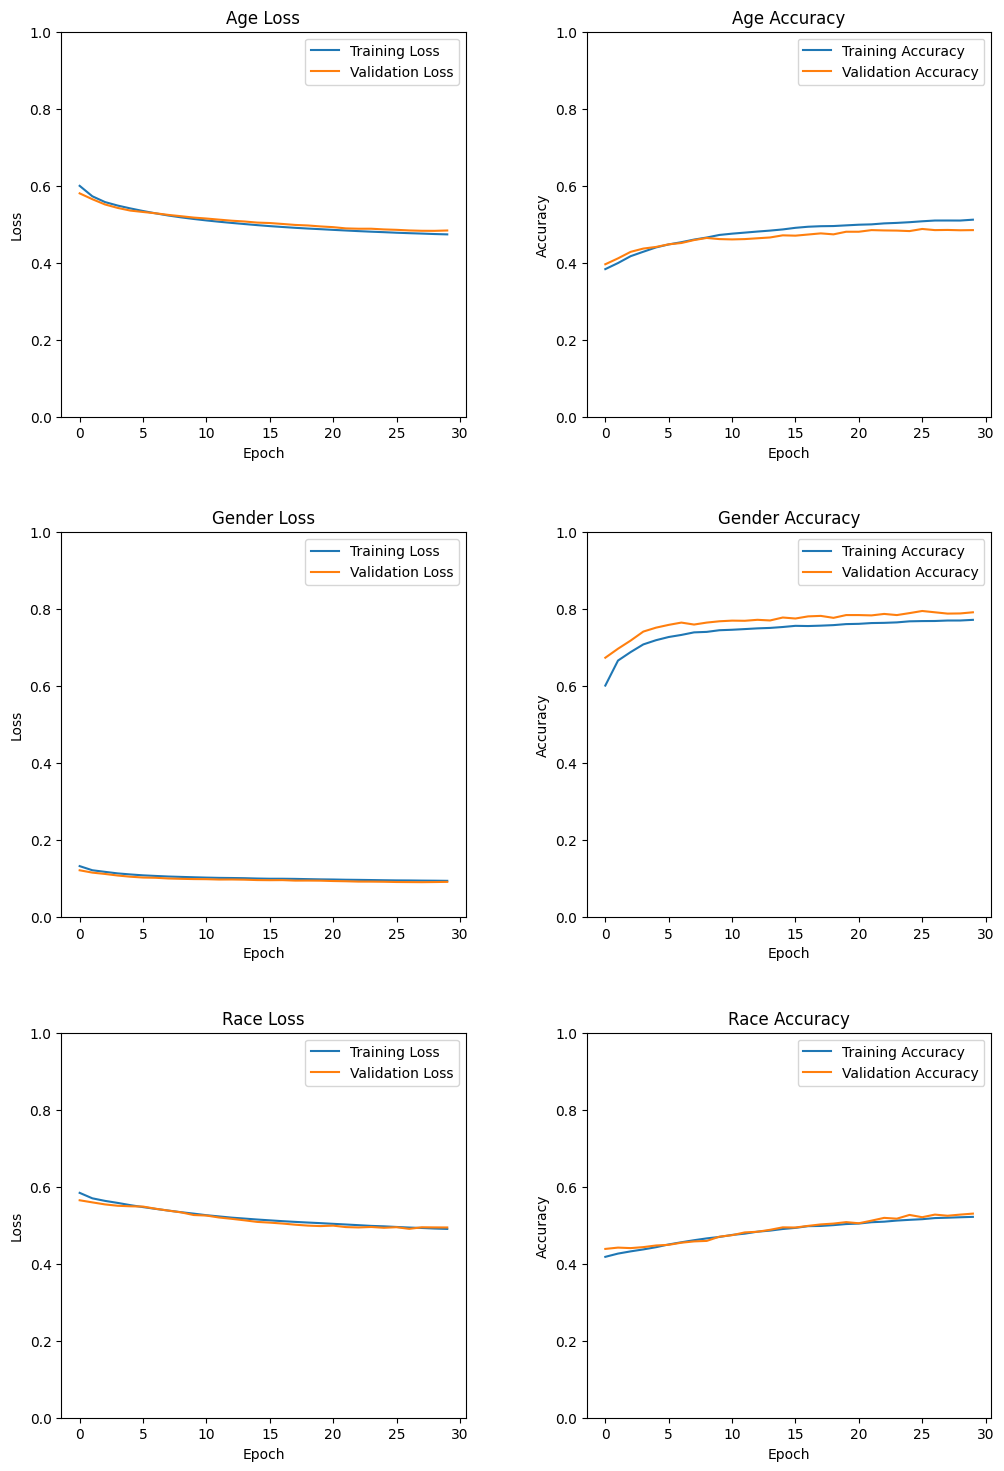

In [ ]:
# Extracting task-specific data from history
gender_loss = history.history['gender_output_loss']
age_loss = history.history['age_output_loss']
race_loss = history.history['race_output_loss']

val_gender_loss = history.history['val_gender_output_loss']
val_age_loss = history.history['val_age_output_loss']
val_race_loss = history.history['val_race_output_loss']

gender_acc = history.history['gender_output_accuracy']
age_acc = history.history['age_output_accuracy']
race_acc = history.history['race_output_accuracy']

val_gender_acc = history.history['val_gender_output_accuracy']
val_age_acc = history.history['val_age_output_accuracy']
val_race_acc = history.history['val_race_output_accuracy']

# Plotting loss curves
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Loss plots
axs[0, 0].plot(age_loss, label='Training Loss')
axs[0, 0].plot(val_age_loss, label='Validation Loss')
axs[0, 0].set_title('Age Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim([0, 1])
axs[0, 0].legend()

axs[1, 0].plot(gender_loss, label='Training Loss')
axs[1, 0].plot(val_gender_loss, label='Validation Loss')
axs[1, 0].set_title('Gender Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_ylim([0, 1])
axs[1, 0].legend()

axs[2, 0].plot(race_loss, label='Training Loss')
axs[2, 0].plot(val_race_loss, label='Validation Loss')
axs[2, 0].set_title('Race Loss')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].set_ylim([0, 1])
axs[2, 0].legend()

# Accuracy plots
axs[0, 1].plot(age_acc, label='Training Accuracy')
axs[0, 1].plot(val_age_acc, label='Validation Accuracy')
axs[0, 1].set_title('Age Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_ylim([0, 1])
axs[0, 1].legend()

axs[1, 1].plot(gender_acc, label='Training Accuracy')
axs[1, 1].plot(val_gender_acc, label='Validation Accuracy')
axs[1, 1].set_title('Gender Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_ylim([0, 1])
axs[1, 1].legend()

axs[2, 1].plot(race_acc, label='Training Accuracy')
axs[2, 1].plot(val_race_acc, label='Validation Accuracy')
axs[2, 1].set_title('Race Accuracy')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('Accuracy')
axs[2, 1].set_ylim([0, 1])
axs[2, 1].legend()

plt.show()

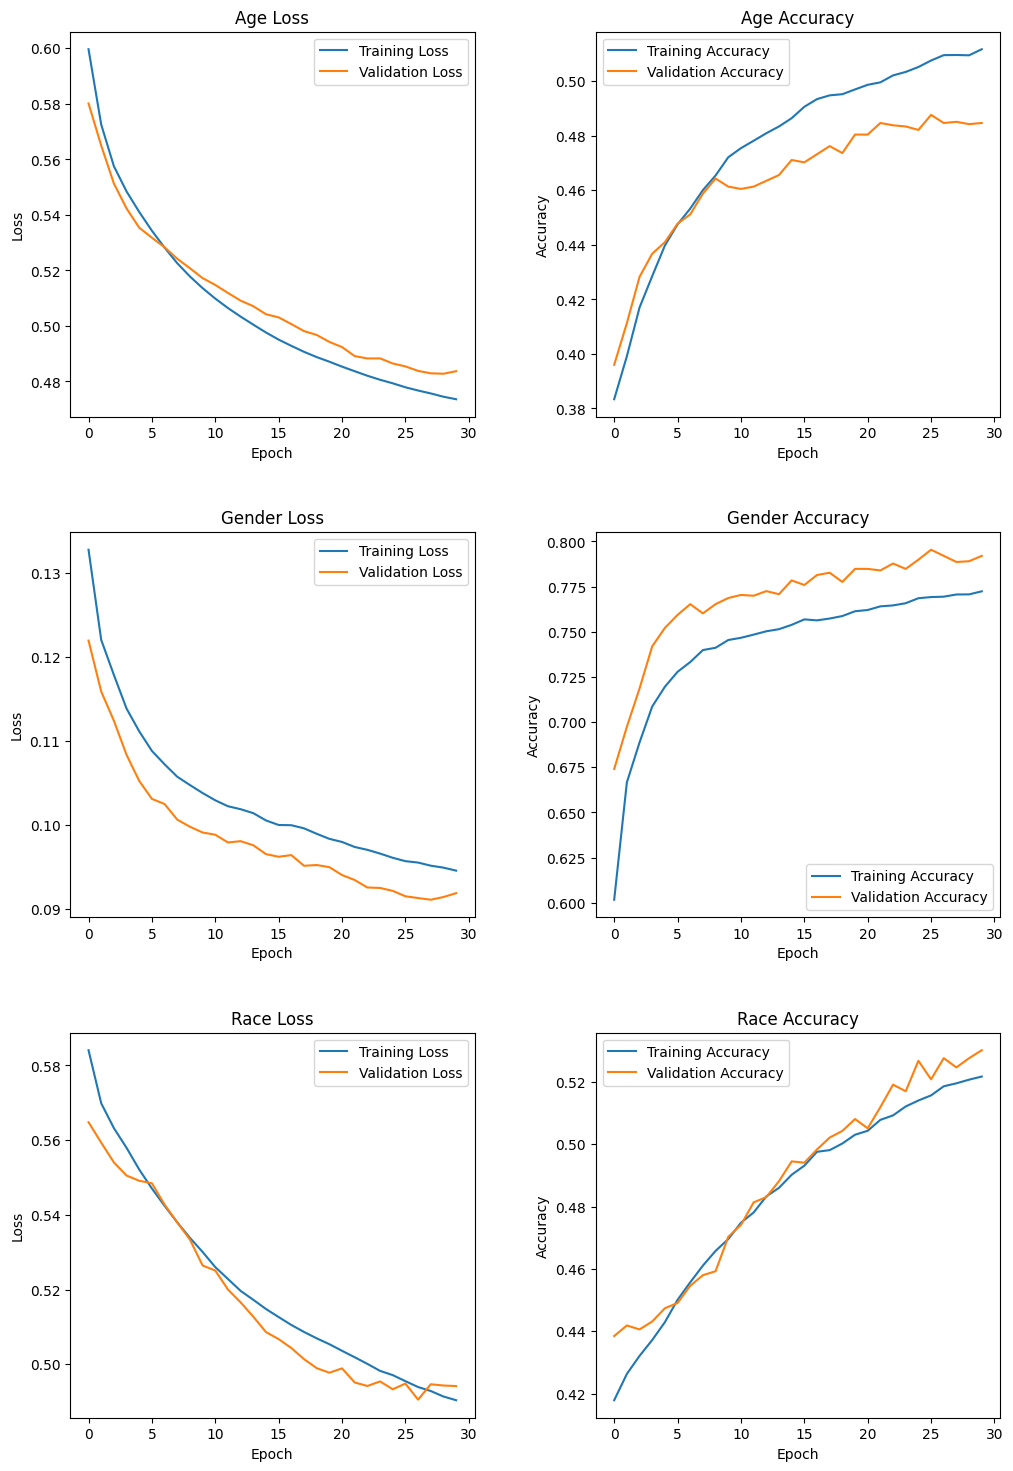

In [ ]:
# Extracting task-specific data from history
gender_loss = history.history['gender_output_loss']
age_loss = history.history['age_output_loss']
race_loss = history.history['race_output_loss']

val_gender_loss = history.history['val_gender_output_loss']
val_age_loss = history.history['val_age_output_loss']
val_race_loss = history.history['val_race_output_loss']

gender_acc = history.history['gender_output_accuracy']
age_acc = history.history['age_output_accuracy']
race_acc = history.history['race_output_accuracy']

val_gender_acc = history.history['val_gender_output_accuracy']
val_age_acc = history.history['val_age_output_accuracy']
val_race_acc = history.history['val_race_output_accuracy']

# Plotting loss curves
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Loss plots
axs[0, 0].plot(age_loss, label='Training Loss')
axs[0, 0].plot(val_age_loss, label='Validation Loss')
axs[0, 0].set_title('Age Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

axs[1, 0].plot(gender_loss, label='Training Loss')
axs[1, 0].plot(val_gender_loss, label='Validation Loss')
axs[1, 0].set_title('Gender Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

axs[2, 0].plot(race_loss, label='Training Loss')
axs[2, 0].plot(val_race_loss, label='Validation Loss')
axs[2, 0].set_title('Race Loss')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].legend()

# Accuracy plots
axs[0, 1].plot(age_acc, label='Training Accuracy')
axs[0, 1].plot(val_age_acc, label='Validation Accuracy')
axs[0, 1].set_title('Age Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

axs[1, 1].plot(gender_acc, label='Training Accuracy')
axs[1, 1].plot(val_gender_acc, label='Validation Accuracy')
axs[1, 1].set_title('Gender Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

axs[2, 1].plot(race_acc, label='Training Accuracy')
axs[2, 1].plot(val_race_acc, label='Validation Accuracy')
axs[2, 1].set_title('Race Accuracy')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('Accuracy')
axs[2, 1].legend()

plt.show()

### Evaluating the model

The following code loads the best saved model and evaluates its performance on the test dataset. This shows the test losses and accuracies for age group, gender and race classifications.

In [ ]:
# Loading the weights of the model with the best validation accuracy
model.load_weights(checkpoint_path)

# Evaluating the model on the test dataset
evaluation_results = model.evaluate(test_ds, verbose=2)

# Extracting and displaying the results for each task
print("")
print(f"Overall test loss = {np.round(evaluation_results[0], 4)}")

# Task-specific losses
age_loss = np.round(evaluation_results[1], 4)
gender_loss = np.round(evaluation_results[2], 4)
race_loss = np.round(evaluation_results[3], 4)
print(f"Age loss = {age_loss}")
print(f"Gender loss = {gender_loss}")
print(f"Race loss = {race_loss}")

# Task-specific accuracies
age_acc = np.round(evaluation_results[4], 4)
gender_acc = np.round(evaluation_results[5], 4)
race_acc = np.round(evaluation_results[6], 4)
print(f"Age accuracy = {age_acc}")
print(f"Gender accuracy = {gender_acc}")
print(f"Race accuracy = {race_acc}")

148/148 - 254s - 2s/step - age_output_accuracy: 0.5091 - age_output_loss: 0.4717 - gender_output_accuracy: 0.7832 - gender_output_loss: 0.0934 - loss: 1.0683 - race_output_accuracy: 0.4943 - race_output_loss: 0.5029

Overall test loss = 1.0683
Age loss = 0.4717
Gender loss = 0.0934
Race loss = 0.5029
Age accuracy = 0.5091
Gender accuracy = 0.7832
Race accuracy = 0.4943


### Visualising some predictions made by ResNet50 model

The following code evaluates the model's predictions for age, gender, and race classifications on a test dataset. It includes preprocessing reversal for visualizing images, label definitions for each task, and plotting functions. Predictions are obtained by running the model on test dataset (test_ds), and the true labels and images are extracted for comparison. It selects 25 random images from the test set and plots them with predicted and true labels for each task (age, gender, and race). Thus, this visualisation contains 75 random test images and helps assess model performance and understand where predictions align or diverge from ground truth.

In [ ]:
# String labels for each task
age_labels = ["0-14", "14-25", "25-40", "40-60", "60+"]
gender_labels = ["Male", "Female"]
race_labels = ["White", "Black", "Asian", "Indian", "Others"]

# Getting predictions for test data
predicted_scores = model.predict(test_ds)
predicted_age = np.argmax(predicted_scores[0], axis=1)
predicted_gender = np.argmax(predicted_scores[1], axis=1)
predicted_race = np.argmax(predicted_scores[2], axis=1)

# Initializing lists to store images and true labels for each task
true_age = []
true_gender = []
true_race = []
images = []

# Collecting images and labels from the test dataset
for image_batch, label_batch in test_ds:
    images.append(image_batch.numpy())
    true_gender.append(label_batch['gender_output'].numpy())
    true_age.append(label_batch['age_output'].numpy())
    true_race.append(label_batch['race_output'].numpy())

# Converting lists to single NumPy arrays
images = np.concatenate(images, axis=0)
true_age = np.concatenate(true_age, axis=0)
true_gender = np.concatenate(true_gender, axis=0)
true_race = np.concatenate(true_race, axis=0)

# Selecting 25 random indices
random_indices = np.random.choice(len(images), size=25, replace=False)

# Function to plot images for a specific task
def plot_task_images(task_name, predicted_labels, true_labels, string_labels):
    f, ax = plt.subplots(5, 5, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax = ax.ravel()

    for i, idx in enumerate(random_indices):
        ax[i].imshow(images[idx])
        ax[i].set_title(
            f"{task_name}\nPred: {string_labels[predicted_labels[idx]]}\nTrue: {string_labels[true_labels[idx]]}"
        )
        ax[i].title.set_size(8)
        ax[i].axis('off')

    plt.show()

# Plot predictions for each task
plot_task_images("Age Group", predicted_age, true_age, age_labels)
plot_task_images("Gender", predicted_gender, true_gender, gender_labels)
plot_task_images("Race", predicted_race, true_race, race_labels)


### Visualising the confusion matrix

The following code generates and visualizes confusion matrices for the model's predictions on age, gender, and race classifications. The plot_confusion_matrix function computes the confusion matrix by comparing predicted labels with true labels and displays it using ConfusionMatrixDisplay. It visualizes the matrices for age (5 classes, red color map), gender (2 classes, blue color map), and race (5 classes, green color map), providing insights into classification performance.

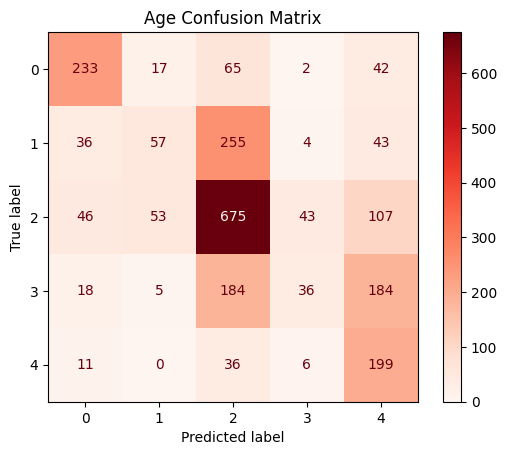

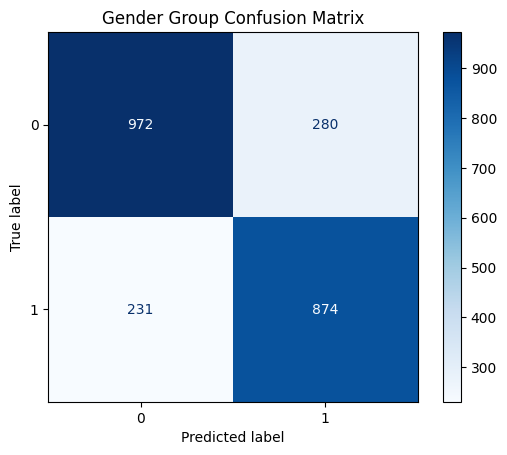

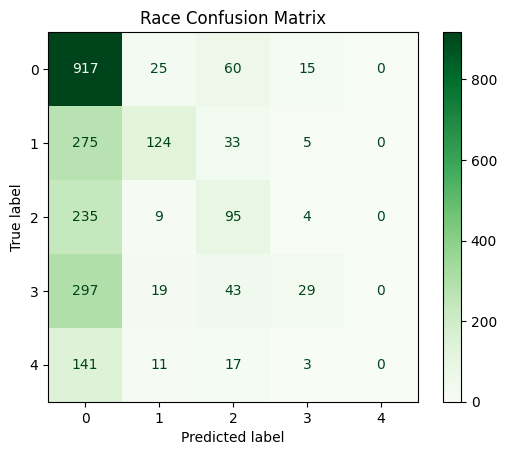

In [ ]:
# Plotting confusion matrices
def plot_confusion_matrix(predicted_labels, true_labels, classes, cmap, title):
    y_pred= [label for label in predicted_labels]
    y_true = [label for label in true_labels]
    classes = np.arange(classes)
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=cmap)
    plt.title(title)
    plt.show()


# Gender confusion matrix
plot_confusion_matrix(predicted_age, true_age, classes = 5, cmap = 'Reds', title = "Age Confusion Matrix")

# Age confusion matrix
plot_confusion_matrix(predicted_gender, true_gender, classes = 2, cmap ='Blues', title = "Gender Group Confusion Matrix")

# Race confusion matrix
plot_confusion_matrix(predicted_race, true_race, classes = 5, cmap ='Greens', title = "Race Confusion Matrix")

### Classification report

The following code generates detailed classification reports for the model's performance on age, gender, and race predictions. Using the classification_report function, it compares true labels with predicted labels for each task, providing metrics like precision, recall, and F1-score for all classes.

In [ ]:
age_labels = ["0-14", "14-25", "25-40", "40-60", "60+"]
gender_labels = ["Male", "Female"]
race_labels = ["White", "Black", "Asian", "Indian", "Others"]

# Generating classification reports for each task
age_report = classification_report(true_age, predicted_age, target_names=age_labels)
gender_report = classification_report(true_gender, predicted_gender, target_names=gender_labels)
race_report = classification_report(true_race, predicted_race, target_names=race_labels)

# Printing the reports
print("\nClassification Report for Age Group:")
print(age_report)

print("\nClassification Report for Gender:")
print(gender_report)

print("\nClassification Report for Race:")
print(race_report)


Classification Report for Age Group:
              precision    recall  f1-score   support

        0-14       0.68      0.65      0.66       359
       14-25       0.43      0.14      0.22       395
       25-40       0.56      0.73      0.63       924
       40-60       0.40      0.08      0.14       427
         60+       0.35      0.79      0.48       252

    accuracy                           0.51      2357
   macro avg       0.48      0.48      0.43      2357
weighted avg       0.50      0.51      0.46      2357


Classification Report for Gender:
              precision    recall  f1-score   support

        Male       0.81      0.78      0.79      1252
      Female       0.76      0.79      0.77      1105

    accuracy                           0.78      2357
   macro avg       0.78      0.78      0.78      2357
weighted avg       0.78      0.78      0.78      2357


Classification Report for Race:
              precision    recall  f1-score   support

       White       0.49

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## References

Deng, J., Dong, W., Socher, R., Li, L.J., Li, K. and Fei-Fei, L. (2009). 'Imagenet: A large-scale hierarchical image database'. *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*. IEEE, pp.248-255. Available at: https://10.1109/CVPR.2009.5206848.

Deng, J., Guo, J., Ververas, E., Kotsia, I. and Zafeiriou, S. (2020). RetinaFace: Single-Shot Multi-Level Face Localisation in the Wild. 2020 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR). Available at: https://doi.org/10.1109/cvpr42600.2020.00525.

He, K., Zhang, X., Ren, S. and Sun, J. (2016). 'Deep Residual Learning for Image Recognition'. *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*. IEEE, pp.770-778. Available at: https://doi.org/10.1109/cvpr.2016.90.

Song, Y., Zhang, Z. and Qi, H. (2017). [online] UTKFace: A Large Scale Face Dataset. Available at: https://susanqq.github.io/UTKFace/.